In [33]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score

palette={"Original": "#80EBC0", "RFA": "#E7274E", 
                     "RBA": '#F6DF83', "Corrected BA": "#197FCD", "Real": '#311162'}


def hadamard(v, L):
    """ Hadamard matrix multiplication, but without the same memory impact """
    if L == 0:
        return v
    a1 = 1/2*hadamard(v[:2**(L-1)], L-1)
    a2 = 1/2*hadamard(v[2**(L-1):], L-1)
    return np.concatenate((a1+a2, -a1+a2), axis=0) 


## define the different epistatic inference methods

def RB_LS_inference(measured_phenotypes, genotypes, degree, L, test_frac=0):
    """ Reference-based, least-square method (Original) 
        degree: maximum order of the model
        L: number of sites
        test_frac: proportion of sites in the test subset (in a test/train formalism)
    """
    poly = PolynomialFeatures(degree, interaction_only=True)
    ## select a random 1/5 subset of the coefficients for testing
    int_genotypes = [int(a, 2) for a in genotypes]
    idx_test_geno = np.random.choice(range(len(genotypes)),  int(len(measured_phenotypes)*test_frac), replace=False)
    test_geno = [int_genotypes[ii] for ii in idx_test_geno]
    idx_train_geno = [a for a in range(len(genotypes)) if a not in idx_test_geno]
    train_geno = [int_genotypes[ii] for ii in idx_train_geno]
    
    geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in train_geno])
    result_opt = scipy.linalg.lstsq(
        geno, measured_phenotypes[idx_train_geno])
    res = result_opt[0]
    
    ## measure the r2 on the test and train set
    train_pred = geno @ res
    # Calculating R-squared
    r2_train = r2_score(measured_phenotypes[idx_train_geno], train_pred)

    r2_test = 0
    if test_frac != 0:
        poly = PolynomialFeatures(degree, interaction_only=True)
        test_geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in test_geno])
        test_pred = test_geno @ res
        r2_test = r2_score(measured_phenotypes[idx_test_geno], test_pred)
      
    return res, r2_train, r2_test

def RBA_inference(measured_phenotypes, genotypes, degree, L):
    """
    RBA inference, up to order `degree`, with L sites.
    """
    poly = PolynomialFeatures(degree, interaction_only=True)
    lowdegree_values = [int(b, 2) for b in genotypes if b.count('1') <= degree]
    idx_lowdegree_values = [ii for ii, b in enumerate(genotypes) if b.count('1') <= degree]
    geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in lowdegree_values])
    result_opt = scipy.linalg.lstsq(
        geno, measured_phenotypes[idx_lowdegree_values])
    res = result_opt[0]
    ## measure the r2
    geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
    pred = geno @ res

    # Calculating R-squared
    r2 = r2_score(measured_phenotypes, pred)

    return res, r2

def RFA_inference(measured_phenotypes, genotypes, degree, L, test_frac=0):
    """ Reference-free, least-square method (RFA) 
        degree: maximum order of the model
        L: number of sites
        test_frac: proportion of sites in the test subset (in a test/train formalism)
    """
    poly = PolynomialFeatures(degree, interaction_only=True)
    ## select a random 1/5 subset of the coefficients for testing
    int_genotypes = [int(a, 2) for a in genotypes]
    idx_test_geno = np.random.choice(range(len(genotypes)),  int(len(measured_phenotypes)*test_frac), replace=False)
    test_geno = [int_genotypes[ii] for ii in idx_test_geno]
    idx_train_geno = [a for a in range(len(genotypes)) if a not in idx_test_geno]
    train_geno = [int_genotypes[ii] for ii in idx_train_geno]
    
    geno = poly.fit_transform([[2*int(a) - 1 for a in f'{b:0{L}b}'] for b in train_geno])

    result_opt = scipy.linalg.lstsq(
        geno, measured_phenotypes[idx_train_geno])
    res = result_opt[0]
    ## measure the r2 on the test and train set
    train_pred = geno @ res
    # Calculating R-squared
    r2_train = r2_score(measured_phenotypes[idx_train_geno], train_pred)
    
    r2_test = 0
    if test_frac != 0:
        poly = PolynomialFeatures(degree, interaction_only=True)
        test_geno = poly.fit_transform([[2*int(a) - 1 for a in f'{b:0{L}b}'] for b in test_geno])
        test_pred = test_geno @ res
        r2_test = r2_score(measured_phenotypes[idx_test_geno], test_pred)
    
    return res, r2_train, r2_test

def MP_BA_inference(measured_phenotypes, order, L):
    """ Hadamard-reference-free method. Only behave correctly with all genotypes.
    """
    coefficients = hadamard(measured_phenotypes, L)
    # reorder the epistatic coefficients so they are in the same order as the other models
    current_order = [tuple([int(x) for x in f'{a:0{L}b}']) for a in range(2**L)]
    poly_order = [a[-1] for a in sorted([(sum(c), *tuple((-np.array(c))), ii) for ii, c in enumerate(current_order)])]
    coefficients_order = coefficients[poly_order]
    poly = PolynomialFeatures(L, interaction_only=True)
    geno = poly.fit_transform([[2*int(a) - 1 for a in f'{b:0{L}b}'] for b in range(2**L)])
    degree_coefs = poly.powers_.sum(axis=1)
    coefficients_order[degree_coefs > order] = 0
    r2 = r2_score(measured_phenotypes, geno@coefficients_order)
    return coefficients_order, r2

In [52]:
## generate fake data of degree 5
degree = 5
L = 12
poly = PolynomialFeatures(degree, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
real_coefficients = np.zeros(shape=(geno.shape[1]))

counts = poly.powers_.sum(axis=1)
counts = np.bincount(counts)[counts]
for ii in range(geno.shape[1]):
    if poly.powers_[ii].sum() == 0:
        real_coefficients[ii] = np.random.normal(loc=2, scale=1)
    else: # the scale of the coefficient evolve with the number of coefficients considered, so that the variance stays the same
        real_coefficients[ii] = np.random.normal(loc=0, scale=2/np.sqrt(counts[ii]))

real_phenotypes = geno@real_coefficients

results = []
for error in tqdm([0, 0.01, 0.05, 0.1, 0.5, 1, 10]):
    for rep in range(10):
        for order in [2]:
            # add noise
            measured_phenotypes = geno@real_coefficients + error * np.random.normal(size=real_phenotypes.shape)
            BAs, r2BA, _ = RB_LS_inference(measured_phenotypes,[f'{a:0{L}b}' for a in range(2**L)], order, L)
            RBAs, r2RBA = RBA_inference(measured_phenotypes,[f'{a:0{L}b}' for a in range(2**L)], order, L)
            RFAs, r2RFA, _ = RFA_inference(measured_phenotypes,[f'{a:0{L}b}' for a in range(2**L)], order, L)
            backav, r2backav = MP_BA_inference(measured_phenotypes, order, L)

            results += [{'error':error, 'r2': r2RBA, 'model': 'RBA', 'order': order, 'rep': rep}]
            results += [{'error':error, 'r2': r2BA, 'model': 'Original', 'order': order, 'rep': rep}]
            results += [{'error':error, 'r2': r2RFA, 'model': 'RFA', 'order': order, 'rep': rep}]
            results += [{'error':error, 'r2': r2backav, 'model': 'Corrected BA', 'order': order, 'rep': rep}]

  0%|          | 0/7 [00:00<?, ?it/s]

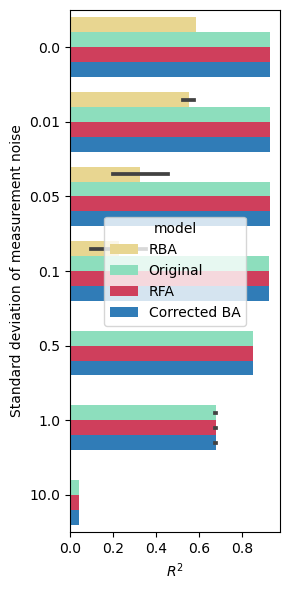

In [53]:
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df.r2 = df.r2.apply(lambda x: x if x > 0 else 0)
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(3, 6))
sns.barplot(data=df, y="error", x="r2", hue="model", orient="h",
            palette=palette,  ax=ax1
).set_ylabel('Standard deviation of measurement noise')#, hue="order & model")

ax1.set_xlabel(f'$R^2$')
# sns.boxplot(data=df[df.model == 'RBA'], y="error", x="r2", hue="model", orient="h",
#             palette={"BA": "mediumaquamarine", "RFA": "mediumvioletred", "RBA": 'gold'}, showfliers=False, ax=ax2
# ).set_xlabel(r'$R^2$')#, hue="order & model")
# ax2.set_xscale('symlog')
# #ax2.set_xlim((-30, 30))

#ax.set_ylim((-1, 1))
plt.tight_layout()
plt.savefig("fig1_panel3.pdf", dpi=600, transparent=True)

In [1]:
## generate fake data of degree 5
degree = 5
L = 12
poly = PolynomialFeatures(degree, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
real_coefficients = np.zeros(shape=(geno.shape[1]))

counts = poly.powers_.sum(axis=1)
counts = np.bincount(counts)[counts]
for ii in range(geno.shape[1]):
    if poly.powers_[ii].sum() == 0:
        real_coefficients[ii] = np.random.normal(loc=2, scale=1)
    else: # the scale of the coefficient evolve with the number of coefficients considered, so that the variance stays the same
        real_coefficients[ii] = np.random.normal(loc=0, scale=2/np.sqrt(counts[ii]))

real_phenotypes = geno@real_coefficients

resultssparse = []

for pcent in tqdm([0.9, 0.5, 0.1, 0.05]):
    for rep in range(10):
        for order in [2]:
            # add noise
            measured_phenotypes = geno@real_coefficients
            sampled = np.random.choice(range(2**L), size=int(pcent*2**L), replace=False)
            BAs, rba, _ = RB_LS_inference(measured_phenotypes[sampled],[f'{a:0{L}b}' for a in sampled],
                                        order , L)
            RFAs, rfa, _ = RFA_inference(measured_phenotypes[sampled],[f'{a:0{L}b}' for a in sampled], 
                                           order, L)
            poly = PolynomialFeatures(order, interaction_only=True)
            genoBA = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
            poly = PolynomialFeatures(order, interaction_only=True)
            genoRFA = poly.fit_transform([[2*int(a) - 1 for a in f'{b:0{L}b}'] for b in range(2**L)])
            
            r2BA = r2_score(measured_phenotypes, genoBA@BAs)
            r2RFA = r2_score(measured_phenotypes, genoRFA@RFAs)
            
            resultssparse += [{'pcent':round(1-pcent, 6), 'r2': r2BA, 'model': 'Original', 'order': order, 'rep': rep}]
            resultssparse += [{'pcent':round(1-pcent, 6), 'r2': r2RFA, 'model': 'RFA', 'order': order, 'rep': rep}]
      

NameError: name 'PolynomialFeatures' is not defined

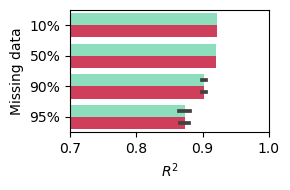

In [39]:
import matplotlib.pyplot as plt

df = pd.DataFrame(resultssparse)
#df.r2 = df.r2.apply(lambda x: x if x > 0 else 0)
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(3, 2))
sns.barplot(data=df, y="pcent", x="r2", hue="model", orient="h",
            palette=palette,  ax=ax1
).set_ylabel('Missing data')#, hue="order & model")

a = ax1.get_yticklabels()[0]
ax1.set_yticklabels([f'{int(float(b.get_text())*100)}%' for b in ax1.get_yticklabels()])

ax1.set_xlabel(f'$R^2$')
ax1.set_xlim((0.7, 1))
ax1.legend().remove()
# sns.boxplot(data=df[df.model == 'RBA'], y="error", x="r2", hue="model", orient="h",
#             palette={"BA": "mediumaquamarine", "RFA": "mediumvioletred", "RBA": 'gold'}, showfliers=False, ax=ax2
# ).set_xlabel(r'$R^2$')#, hue="order & model")
# ax2.set_xscale('symlog')
# #ax2.set_xlim((-30, 30))

#ax.set_ylim((-1, 1))
plt.tight_layout()
plt.savefig("fig1_panel4.pdf", dpi=600, transparent=True)

In [40]:
## generate fake data of degree 5
degree = 5
L = 12
poly = PolynomialFeatures(degree, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
real_coefficients = np.zeros(shape=(geno.shape[1]))

counts = poly.powers_.sum(axis=1)
counts = np.bincount(counts)[counts]
for ii in range(geno.shape[1]):
    if poly.powers_[ii].sum() == 0:
        real_coefficients[ii] = np.random.normal(loc=2, scale=1)
    else: # the scale of the coefficient evolve with the number of coefficients considered, so that the variance stays the same
        real_coefficients[ii] = np.random.normal(loc=0, scale=2/np.sqrt(counts[ii]))

real_phenotypes = geno@real_coefficients

coef_errors = []

for order in range(5):
    realBAs, _, _ = RB_LS_inference(real_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], order , L)
    realRFAs, _, _ = RFA_inference(real_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], order, L)
    for rep in tqdm(range(100)):
        measured_phenotypes = geno@real_coefficients + 0.1* np.random.normal(size=real_phenotypes.shape)
        BAs, _, _ = RB_LS_inference(measured_phenotypes,[f'{a:0{L}b}' for a in range(2**L)], order , L)
        RFAs, _, _ = RFA_inference(measured_phenotypes,[f'{a:0{L}b}' for a in range(2**L)], order, L)
        
        poly = PolynomialFeatures(order, interaction_only=True)
        poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
        # separate according to order
        for pw, coefrba, coefrba_real in zip(poly.powers_, BAs, realBAs):
            coef_errors += [{'abs_error':np.abs(coefrba-coefrba_real)/np.abs(coefrba_real), 'order_coef': pw.sum(),
                            'total_order': order, 'rep': rep, 'model': 'Original'}]
            
        poly = PolynomialFeatures(order, interaction_only=True)
        poly.fit_transform([[2*int(a)-1 for a in f'{b:0{L}b}'] for b in range(2**L)])
        for pw, coefrfa, coefrfa_real in zip(poly.powers_, RFAs, realRFAs):
            coef_errors += [{'abs_error':np.abs(coefrfa-coefrfa_real)/np.abs(coefrfa_real), 'order_coef': pw.sum(),
                            'total_order': order, 'rep': rep, 'model': 'RFA'}]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0
1
2
3


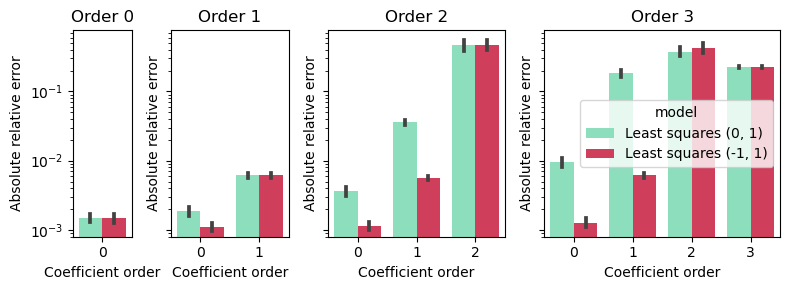

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(coef_errors)
df['Model order'] = df['total_order']
# Create the FacetGrid
fig, axes = plt.subplots(1, 4, sharey=True, width_ratios=[1,2,3,4], figsize=(8, 3))

for ax, total_order in zip(axes, range(5)):
    print(total_order)
    subset_data = df[df["total_order"] == total_order]
    sns.barplot(x="order_coef", y="abs_error", hue="model",
                data=subset_data[subset_data.order_coef <= total_order],palette=palette,
                ax=ax, order=range(total_order+1))
    ax.set_yscale('log')
    ax.set_ylabel("Absolute relative error")
    ax.set_xlabel('Coefficient order')
    ax.set_title(f'Order {total_order}')
    if total_order < 3:
        ax.legend().remove()
    



plt.tight_layout()
plt.show()

#plt.savefig("fig1_panel3.pdf", dpi=600, transparent=True)

In [79]:
## Generate a semi-realistic random model of order 3, with 12 sites
degree = 3
L = 12
poly = PolynomialFeatures(degree, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
real_coefficients = np.zeros(shape=(geno.shape[1]))

counts = poly.powers_.sum(axis=1)
counts = np.bincount(counts)[counts]
for ii in range(geno.shape[1]):
    if poly.powers_[ii].sum() == 0:
        real_coefficients[ii] = np.random.normal(loc=2, scale=1)
    else: # the scale of the coefficient evolve with the number of coefficients considered, so that the variance stays the same
        real_coefficients[ii] = np.random.normal(loc=0, scale=2)#/np.sqrt(counts[ii]))

real_phenotypes = geno@real_coefficients

# add a small noise
measured_phenotypes = geno@real_coefficients + 2 * np.random.normal(size=real_phenotypes.shape)

results = []
# Look at the prediction of a linear model CV as the number of coefficients grow
for _ in tqdm(range(20)): # run the bootstrap a few times
    for deg in range(0,6):
        _, r2train, r2test = RB_LS_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], deg, L, 1/5)
        results += [{'r2': r2test, 'type': 'test', 'model':'Original', 'degree': deg}]
        results += [{'r2': r2train, 'type': 'train', 'model':'Original', 'degree': deg}]

for _ in tqdm(range(20)): # run the bootstrap a few times
    for deg in range(0,6):
        _, r2train, r2test = RFA_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], deg, L, 1/5)
        results += [{'r2': r2test, 'type': 'test', 'model':'RFA','degree': deg}]
        results += [{'r2': r2train, 'type': 'train', 'model':'RFA','degree': deg}]
        
for deg in range(0,6):
    _, r2 = RBA_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], deg, L)
    results += [{'r2': r2, 'type': 'na', 'model':'RBA' ,'degree': deg}]
    
for deg in range(0,6):
    _, r2 = MP_BA_inference(measured_phenotypes, deg, L)
    results += [{'r2': r2, 'type': 'na', 'model':'Corrected BA','degree': deg}]
        
dfresult = pd.DataFrame(results)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [80]:
results = []
## Look at the prediction of a linear model CV as the number of coefficients grow
for deg in range(0,6):
    _, r2train, _ = RB_LS_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], deg, L)
    results += [{'r2': r2train, 'type': 'train', 'model': 'Original', 'degree': deg}]

for deg in range(0,6):
    _, r2train, _ = RFA_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], deg, L)
    results += [{'r2': r2train, 'type': 'train', 'model':'RFA','degree': deg}]
        
for deg in range(0,6):
    _, r2 = RBA_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], deg, L)
    results += [{'r2': r2, 'type': 'na', 'model':'RBA' ,'degree': deg}]
    
for deg in range(0,6):
    _, r2 = MP_BA_inference(measured_phenotypes,  deg, L)
    results += [{'r2': r2, 'type': 'na', 'model':'Corrected BA','degree': deg}]
        
dfresult_fulldat = pd.DataFrame(results)

In [81]:

order3_BA, _, _ = RB_LS_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], 3, L, test_frac=0)
order3_RFA,_ , _ = RFA_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], 3, L, test_frac=0)
order3_RBA, _ = RBA_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], 3, L)
order3_MPBA, _ = MP_BA_inference(measured_phenotypes,  3, L)
order3_MPBA = order3_MPBA[:order3_RFA.shape[0]] # remove 0s
poly = PolynomialFeatures(3, interaction_only=True)
geno_BA = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
geno_RFA = poly.fit_transform([[2*int(a)-1 for a in f'{b:0{L}b}'] for b in range(2**L)])


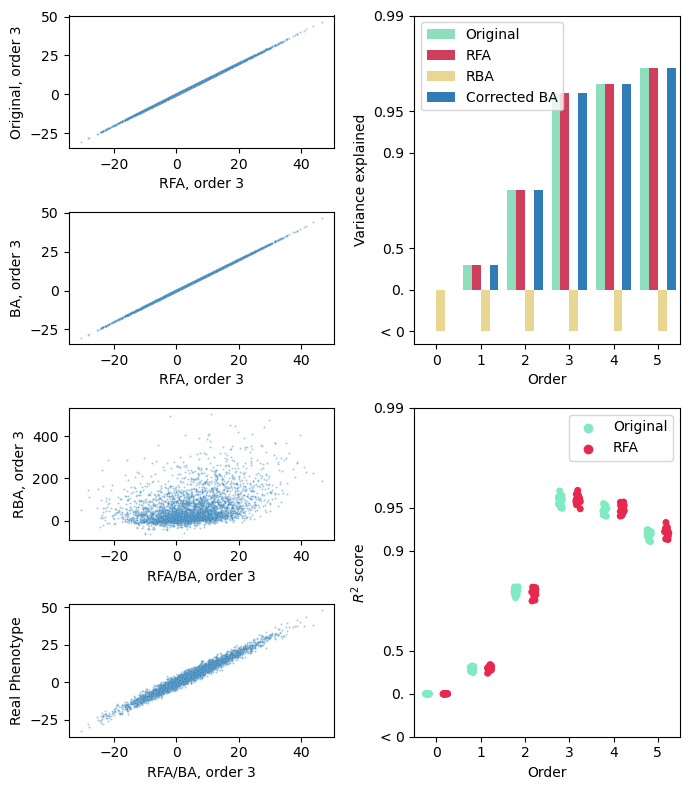

In [85]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7, 8))
gs = gridspec.GridSpec(8, 2)

ax1 = plt.subplot(gs[0:2, 0])
ax6 = plt.subplot(gs[2:4, 0])
ax2 = plt.subplot(gs[4:6, 0])
ax5 = plt.subplot(gs[6:8, 0])
ax3 = plt.subplot(gs[0:4, 1])
ax4 = plt.subplot(gs[4:8, 1])

sns.scatterplot(x=geno_RFA@order3_RFA, y=geno_BA@order3_BA, ax=ax1, alpha=0.4, s=2, rasterized=True)
sns.scatterplot(x=geno_RFA@order3_RFA, y=geno_RFA@order3_MPBA, ax=ax6, alpha=0.4, s=2, rasterized=True)
sns.scatterplot(x=geno_RFA@order3_RFA, y=geno_BA@order3_RBA, ax=ax2, alpha=0.4, s=2, rasterized=True)
sns.scatterplot(x=geno_RFA@order3_RFA, y=measured_phenotypes, ax=ax5, alpha=0.4, s=2, rasterized=True)

ax1.set_xlabel("RFA, order 3")
ax2.set_xlabel("RFA/BA, order 3")
ax1.set_ylabel("Original, order 3")
ax2.set_ylabel("RBA, order 3")
ax5.set_ylabel("Real Phenotype")
ax5.set_xlabel("RFA/BA, order 3")

ax6.set_ylabel("BA, order 3")
ax6.set_xlabel("RFA, order 3")

# Transform your r2 values
dfresult_fulldat['log_r2'] = np.log10(1 - dfresult_fulldat['r2'])
dfresult_fulldat['log_r2'] = dfresult_fulldat['log_r2'].apply(lambda x: x if x < 0.005 else np.log10(2))
sns.barplot(data=dfresult_fulldat, x='degree', y='log_r2', hue='model', 
              palette = palette,
              ax=ax3, dodge=True
)
yticks_transformed = np.log10(1 - np.array([0.99, 0.95, 0.9, 0.5, 0., -1]))
ax3.set_yticks(yticks_transformed, ['0.99', '0.95', '0.9', '0.5', '0.', '< 0'])

ax3.invert_yaxis()
ax3.set_xlabel('Order')
ax3.set_ylabel('Variance explained')
ax3.legend(title='Set')
# Remove duplicate legend entries
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles[:4], labels[:4])

# Transform your r2 values
dfresult['log_r2'] = np.log10(1 - dfresult['r2'])
dfresult['log_r2'] = dfresult['log_r2'].apply(lambda x: x if x < 0.005 else np.log10(2))
sns.stripplot(data=dfresult[dfresult['type'].isin(['test'])], x='degree', y='log_r2', hue='model', 
              palette = palette,
              ax=ax4, dodge=True
)
# Custom y-ticks: transform them back to the original scale for display
yticks_transformed = np.log10(1 - np.array([0.99, 0.95, 0.9, 0.5, 0., -1]))
ax4.set_yticks(yticks_transformed, ['0.99', '0.95', '0.9', '0.5', '0.', '< 0'])
ax4.invert_yaxis()



ax4.set_xlabel('Order')
ax4.set_ylabel('$R^2$ score')
ax4.legend(title='Set')

# Remove duplicate legend entries
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles[:4], labels[:4])


plt.tight_layout()
plt.savefig('fig1_panel1.pdf', dpi=600)


In [86]:
dfresult = pd.read_csv('./reanalysis_h1.csv')
dfresult_fulldat = pd.read_csv('./reanalysis_h1_fulldat.csv')
order5_RBA = np.load('order5_RBA.npy')
order5_BA = np.load('order5_BA.npy')
order5_RFA = np.load('order5_RFA.npy')
order5_MP_BA = np.load('order5_MP_BA.npy')
measured_phenotypes = np.load('H1_measured_phenotypes.npy')
dfresult_fulldat.model = dfresult_fulldat.model.map({'BA': 'Corrected BA', 'RFA': 'RFA', 'Least squares (0, 1)': 'Original', 'No average (0, 1)': 'RBA'})
dfresult.model = dfresult.model.map({'Hadamard (-1, 1)': 'Corrected BA', 'Least squares (-1, 1)': 'RFA', 'Least squares (0, 1)': 'Original', 'No average (0, 1)': 'RBA'})

dfresult_fulldat = pd.concat([dfresult_fulldat.dropna(), dfresult[dfresult.type == 'na']], axis=0)

In [87]:
L = 16
poly = PolynomialFeatures(5, interaction_only=True)
genoRFA = poly.fit_transform([[2*int(a) -1 for a in f'{b:0{L}b}'] for b in range(2**L)])
genoBA = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])

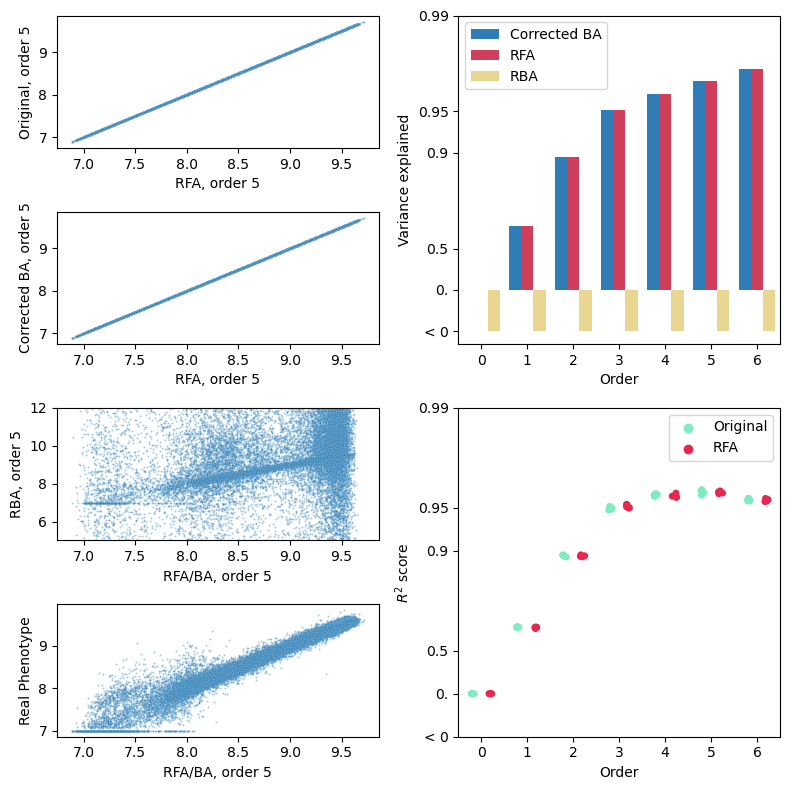

In [88]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(8, 2)

ax1 = plt.subplot(gs[0:2, 0])
ax6 = plt.subplot(gs[2:4, 0])
ax2 = plt.subplot(gs[4:6, 0])
ax5 = plt.subplot(gs[6:8, 0])
ax3 = plt.subplot(gs[0:4, 1])
ax4 = plt.subplot(gs[4:8, 1])

sns.scatterplot(x=genoRFA@order5_RFA, y=genoBA@order5_BA, ax=ax1, alpha=0.4, s=2, rasterized=True)
sns.scatterplot(x=genoRFA@order5_RFA, y=genoRFA@order5_MP_BA[:genoRFA.shape[1]], ax=ax6, alpha=0.4, s=2, rasterized=True)
sns.scatterplot(x=genoRFA@order5_RFA, y=genoBA@order5_RBA, ax=ax2, alpha=0.4, s=2, rasterized=True)
sns.scatterplot(x=genoRFA@order5_RFA, y=measured_phenotypes, ax=ax5, alpha=0.4, s=2, rasterized=True)

ax1.set_xlabel("RFA, order 5")
ax2.set_xlabel("RFA/BA, order 5")
ax1.set_ylabel("Original, order 5")
ax2.set_ylabel("RBA, order 5")
ax5.set_ylabel("Real Phenotype")
ax5.set_xlabel("RFA/BA, order 5")
ax2.set_ylim(5, 12)
ax6.set_ylabel("Corrected BA, order 5")
ax6.set_xlabel("RFA, order 5")

# Transform your r2 values
dfresult_fulldat['log_r2'] = np.log10(1 - dfresult_fulldat['r2'])
dfresult_fulldat['log_r2'] = dfresult_fulldat['log_r2'].apply(lambda x: x if x < 0.005 else np.log10(2))
sns.barplot(data=dfresult_fulldat, x='degree', y='log_r2', hue='model', 
              palette = palette,
              ax=ax3, dodge=True
)
yticks_transformed = np.log10(1 - np.array([0.99, 0.95, 0.9, 0.5, 0., -1]))
ax3.set_yticks(yticks_transformed, ['0.99', '0.95', '0.9', '0.5', '0.', '< 0'])
ax3.invert_yaxis()
ax3.set_xlabel('Order')
ax3.set_ylabel('Variance explained')
ax3.legend(title='Set')
# Remove duplicate legend entries
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles[:4], labels[:4])

# Transform your r2 values
dfresult['log_r2'] = np.log10(1 - dfresult['r2'])
dfresult['log_r2'] = dfresult['log_r2'].apply(lambda x: x if x < 0.005 else np.log10(2))
sns.stripplot(data=dfresult[dfresult['type'].isin(['test'])], x='degree', y='log_r2', hue='model', 
              palette = palette,
              ax=ax4, dodge=True
)
# Custom y-ticks: transform them back to the original scale for display
yticks_transformed = np.log10(1 - np.array([0.99, 0.95, 0.9, 0.5, 0., -1]))
ax4.set_yticks(yticks_transformed, ['0.99', '0.95', '0.9', '0.5', '0.', '< 0'])
ax4.invert_yaxis()



ax4.set_xlabel('Order')
ax4.set_ylabel('$R^2$ score')
ax4.legend(title='Set')

# Remove duplicate legend entries
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles[:4], labels[:4])


plt.tight_layout()
plt.savefig('fig1_panel2.pdf', dpi=600)


In [28]:
## Generate a semi-realistic random model of order 3, with 12 sites
## Generate a semi-realistic random model of order 3, with 12 sites
degree = 3
L = 12
poly = PolynomialFeatures(degree, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
real_coefficients = np.zeros(shape=(geno.shape[1]))

counts = poly.powers_.sum(axis=1)
counts = np.bincount(counts)[counts]
for ii in range(geno.shape[1]):
    if poly.powers_[ii].sum() == 0:
        real_coefficients[ii] = np.random.normal(loc=2, scale=1)
    else: # the scale of the coefficient evolve with the number of coefficients considered, so that the variance stays the same
        real_coefficients[ii] = np.random.normal(loc=0, scale=2)#/np.sqrt(counts[ii]))

real_phenotypes = geno@real_coefficients
# add a small noise
measured_phenotypes = geno@real_coefficients + 10 * np.random.normal(size=real_phenotypes.shape)


real_RFA, _, _ = RFA_inference(real_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], 3, L, test_frac=0)
approx_RFA, _, _ = RFA_inference(measured_phenotypes, [f'{a:0{L}b}' for a in range(2**L)], 3, L, test_frac=0)

In [29]:
# make a dataframe with all coefficients (and make them match)
poly = PolynomialFeatures(L, interaction_only=True)
geno = poly.fit_transform([[int(a) for a in f'{b:0{L}b}'] for b in range(2**L)])
orderrfa = [tuple(a) for a in poly.powers_]
us = [f'{a:0{L}b}' for a in range(2**L)]
order = [orderrfa.index(tuple([int(a) for a in b])) for b in us]
fs = [list(np.where(np.array([int(v) for v in u]) != 0)[0]) for u in us]
names = ['int.' if len(f) == 0 else ','.join([str(x) for x in f]) for f in fs]
dfplot = pd.DataFrame()
dfplot['names'] = names
dfplot['coefficient_hadamard'] = V[L]@H[L]@measured_phenotypes
dfplot['order_coef'] = [len(f) for f in fs]
dfplot['full_order'] = order
dfplot['coefficient_RFA'] = [approx_RFA[ii] if ii < len(approx_RFA) else 0 for ii in order]
dfplot['real_coefficient'] = [real_RFA[ii] if ii < len(real_RFA) else 0 for ii in order]

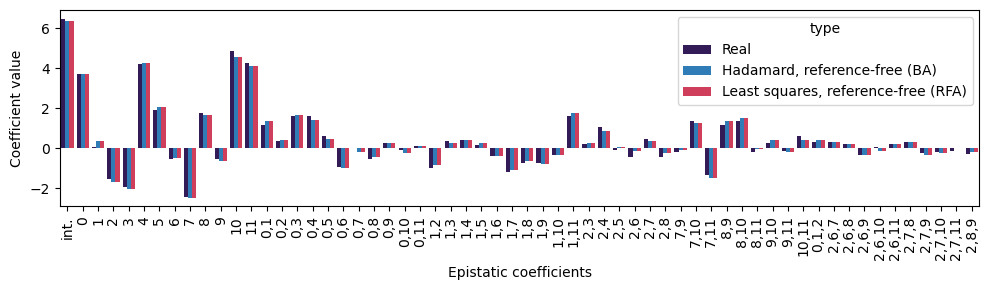

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
dfplot = dfplot.sort_values(by=['full_order'])

# Use melt to unpivot the dataframe
melted_df = dfplot.iloc[list(range(40)) + list(range(70, 80)) + list(range(200, 210))].melt(id_vars=['names'], 
                    value_vars=['real_coefficient', 'coefficient_hadamard', 'coefficient_RFA'], 
                    var_name='type', 
                    value_name='coefficient')
# Replace the type names to match your requirement
melted_df['type'] = melted_df['type'].replace({'real_coefficient': 'Real', 
                                               'coefficient_hadamard': 'Corrected BA', 
                                               'coefficient_RFA': 'RFA'})

fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(data=melted_df, hue='type', x='names', y='coefficient', palette = palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Epistatic coefficients')
ax.set_ylabel('Coefficient value')
plt.tight_layout()
plt.savefig('fig3.pdf')
